In [141]:
try:
    # Check if notebook is running in Google Colab
    import google.colab
    # Get additional files from Github
    !wget https://raw.githubusercontent.com/volkerkrueger/edan95/master/labs/blackjack.py
    !wget https://raw.githubusercontent.com/volkerkrueger/edan95/master/labs/plotting.py
    # Install additional dependencies
    !pip install gym
    !apt-get install python-opengl -y
    import gym
    import matplotlib
    import numpy as np
    import sys
    import time
    from blackjack import BlackjackEnv
    from collections import defaultdict
    import plotting
    matplotlib.style.use('ggplot')
except:
    pass
    %matplotlib inline

#from collections import defaultdict

#from blackjack import BlackjackEnv

--2021-12-14 11:21:06--  https://raw.githubusercontent.com/volkerkrueger/edan95/master/labs/blackjack.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4251 (4.2K) [text/plain]
Saving to: ‘blackjack.py.2’

blackjack.py.2      100%[===================>]   4.15K  --.-KB/s    in 0s      

2021-12-14 11:21:06 (48.2 MB/s) - ‘blackjack.py.2’ saved [4251/4251]

--2021-12-14 11:21:06--  https://raw.githubusercontent.com/volkerkrueger/edan95/master/labs/plotting.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1494 (1.5K) [text/plain]
S

In [142]:
env = BlackjackEnv()

In [143]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    #(action, reward) ? (reward, action)
    def policy_fn(observation):
      probs = []
      for i in range(nA):
        probs.append(epsilon/nA)
      ind = 0
      if observation in Q.keys():
        obs = Q[observation]
        ind = np.argmax(obs)
        #random choice of the best ones
        #ind = np.random.choice(np.where(obs == obs.max())[0])
      else:
        ind = env.action_space.sample()
      probs[ind] += (1-epsilon)

      return probs

    return policy_fn

In [144]:
import copy

In [145]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n)) # N(s,a)
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)


    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        ###############################################################################################
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
          action = np.argmax(policy(state))
          next_state, reward, done, _ = env.step(action)
          #print(state,action,next_state,reward,done)
          episode.append((state, action, reward))
          if done:
              break
          state = next_state
            
        ###############################################################################################
        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([(x[0],x[1]) for x in episode])
        for state, action in states_in_episode:
          # Find the first occurance of the state in the episode
          first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
          # Sum up all rewards since the first occurance
          G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
          # Calculate average return for this state over all sampled episodes
          N[state][action] += 1.0
          Q[state][action] += (1 / N[state][action]) * (G - Q[state][action])
          #print((1 / N[state][action]) * (G - Q[state][action]))


          returns_sum[state] += Q[state][action]
          returns_count[state] += N[state][action]

          #returns_sum[state] += G
          #returns_count[state] += 1.0

        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)


    return Q,policy

  

In [146]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
def m(Q, nbr):
  V = defaultdict(float)
 
  for state, actions in Q.items():
      action_value = np.max(actions)
      V[state] = action_value
  print(nbr)
  plotting.plot_value_function(V, title="Optimal Value Function")

Episode 1000/10000.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Episode 500000/500000.
 159.3694190000001 s
10000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


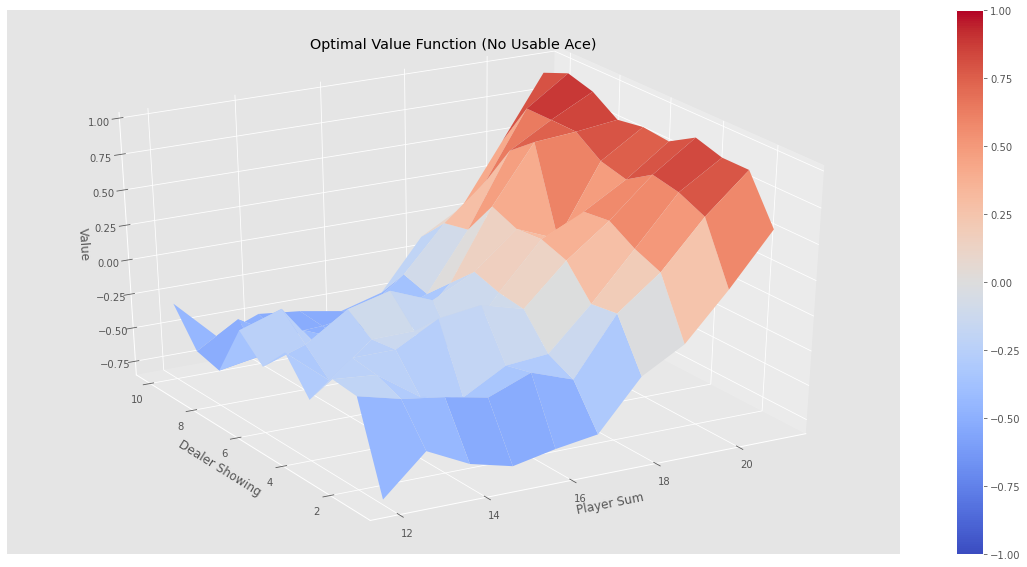

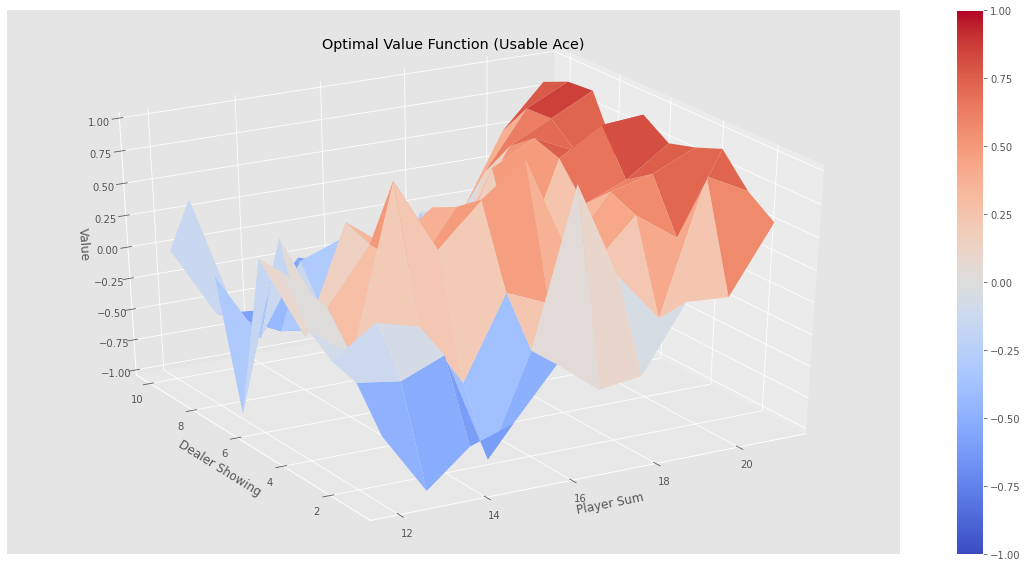

50000


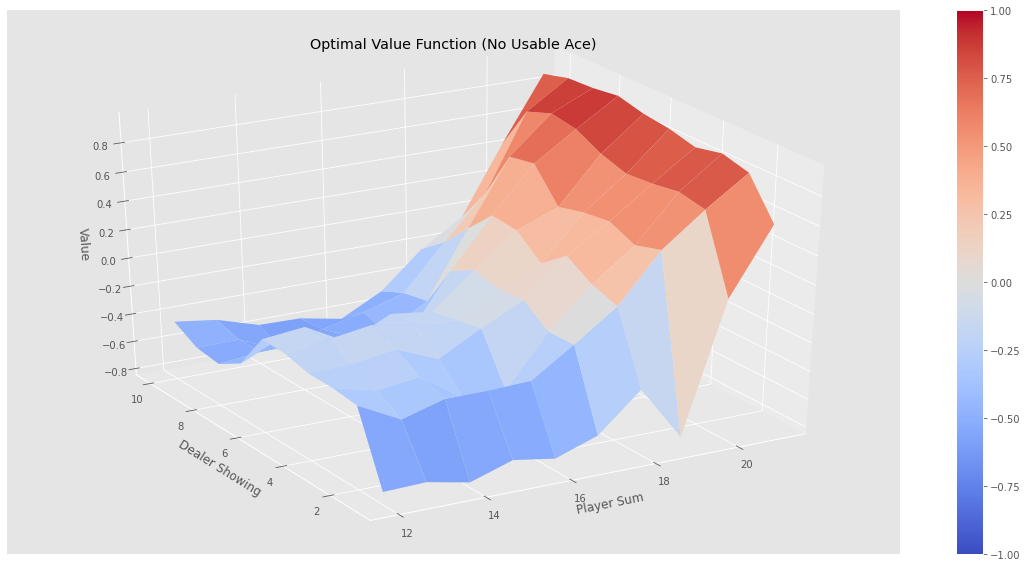

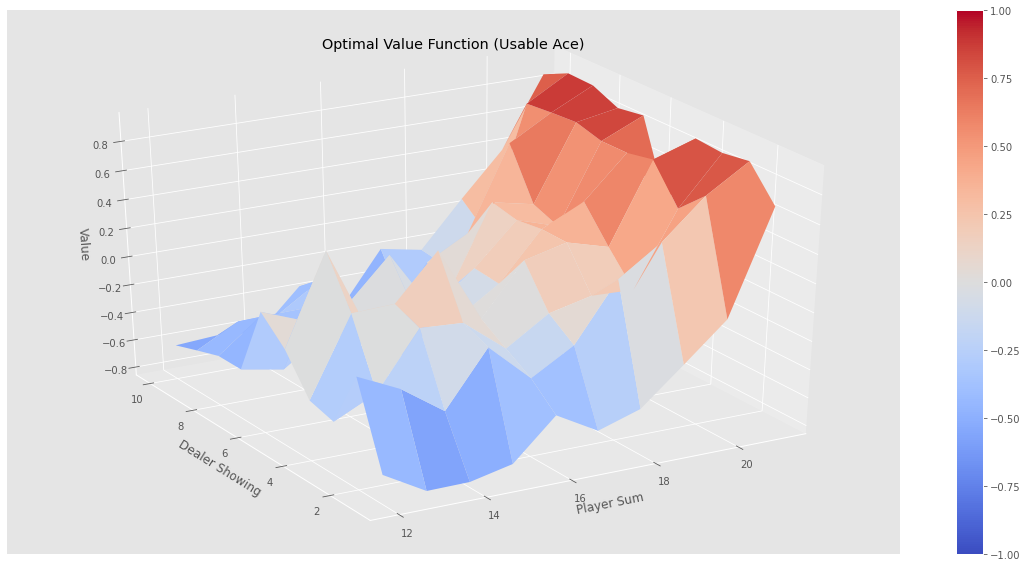

100000


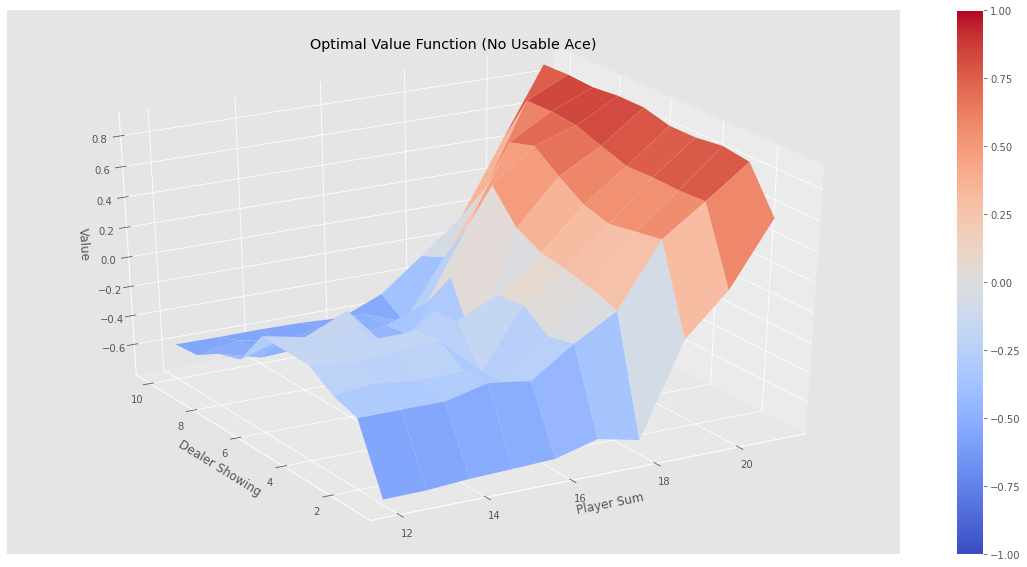

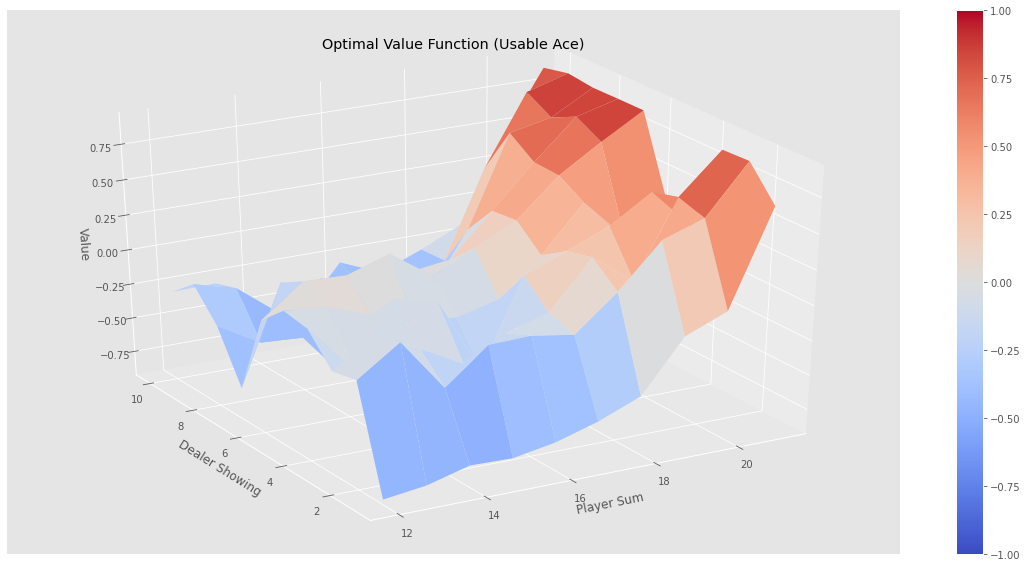

300000


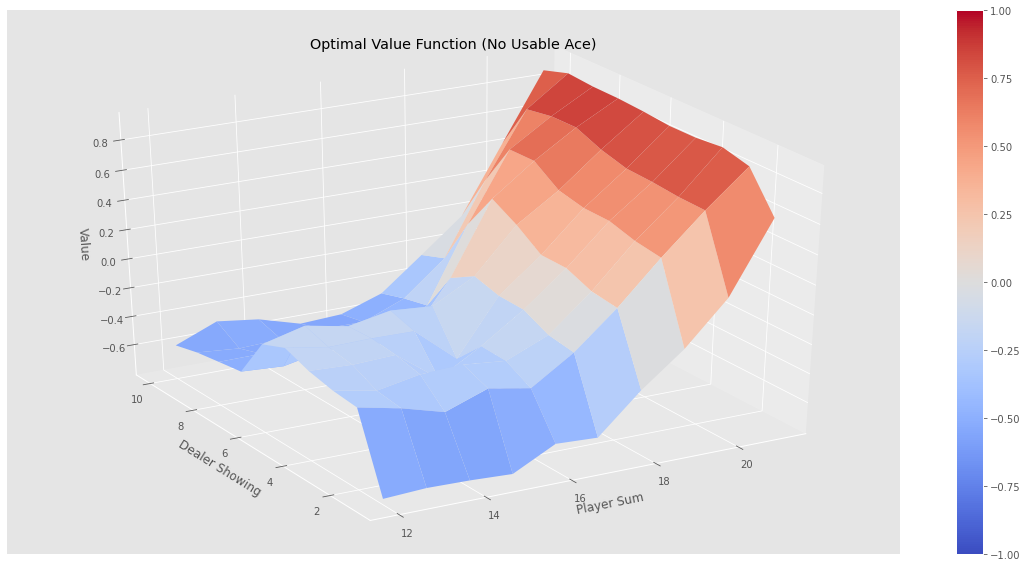

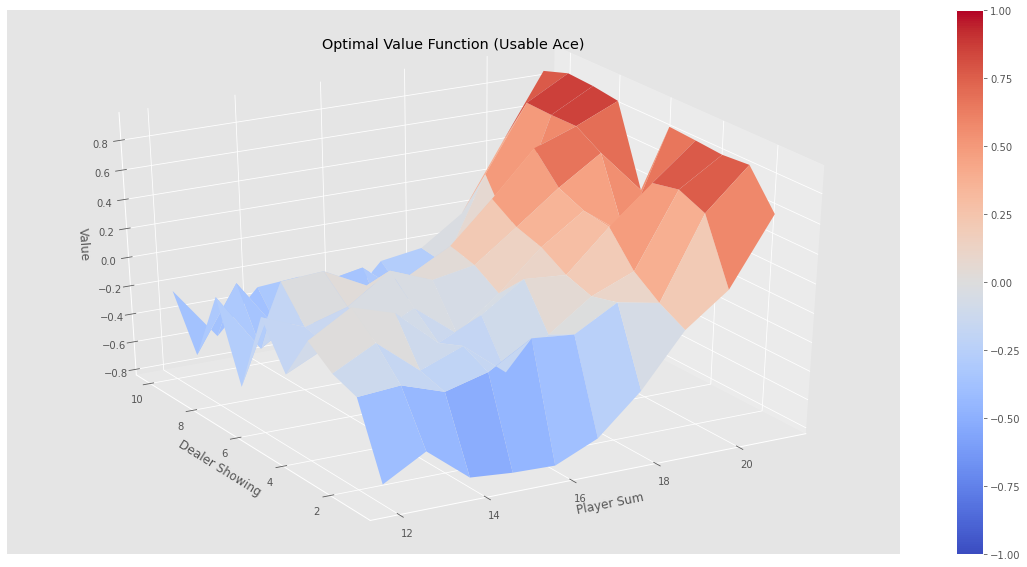

400000


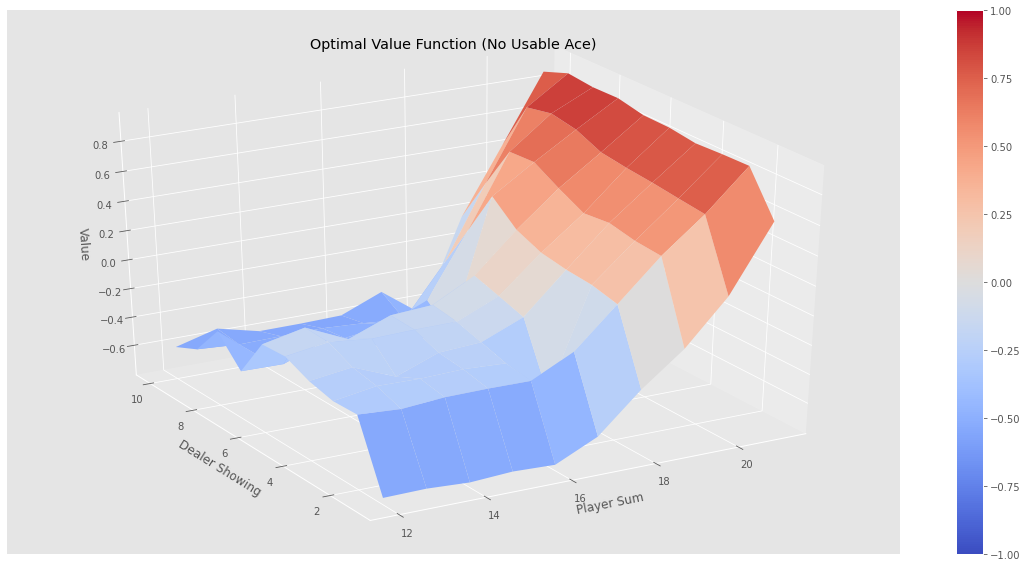

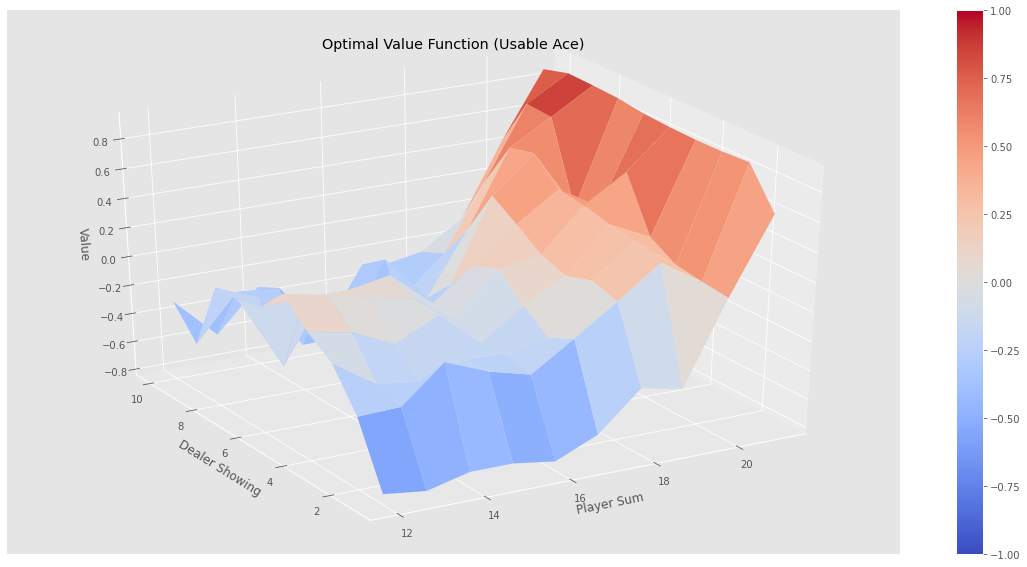

500000


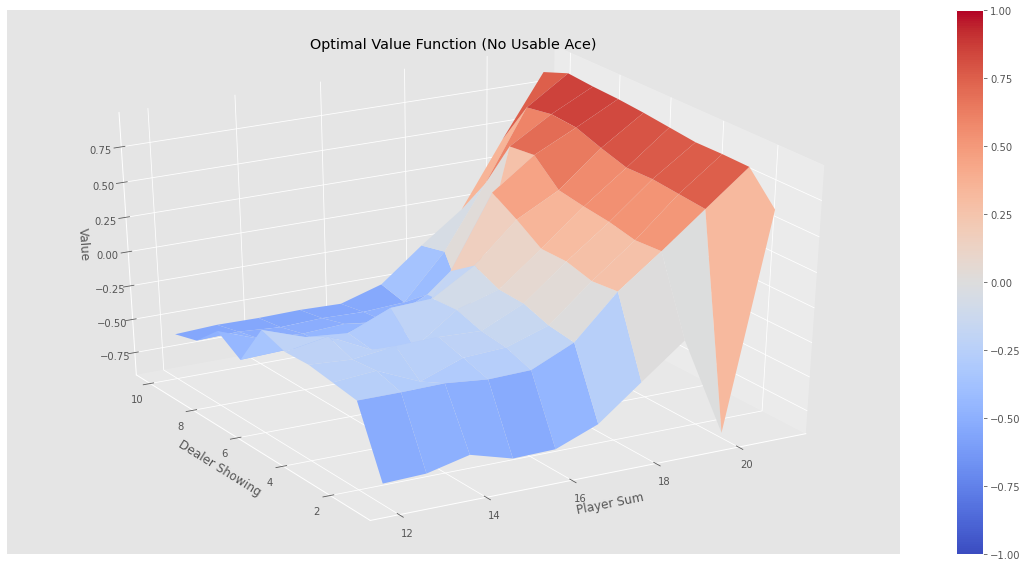

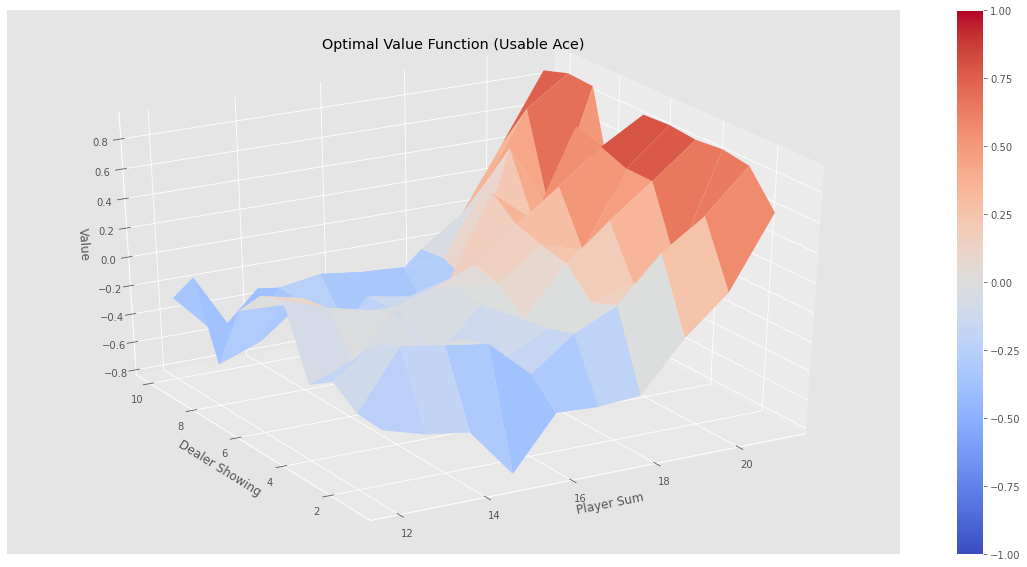

In [147]:
start = time.clock()

Q1, policy = mc_control_epsilon_greedy(env, num_episodes=10000, discount_factor=1.0, epsilon=0.1)
Q2, policy = mc_control_epsilon_greedy(env, num_episodes=50000, discount_factor=1.0, epsilon=0.1)
Q3, policy = mc_control_epsilon_greedy(env, num_episodes=100000, discount_factor=1.0, epsilon=0.1)
Q4, policy = mc_control_epsilon_greedy(env, num_episodes=300000, discount_factor=1.0, epsilon=0.1)
Q5, policy = mc_control_epsilon_greedy(env, num_episodes=400000, discount_factor=1.0, epsilon=0.1)
Q6, policy = mc_control_epsilon_greedy(env, num_episodes=500000, discount_factor=1.0, epsilon=0.1)

end = time.clock()
print("\n",end - start,"s")
m(Q1, 10000)
m(Q2, 50000)
m(Q3, 100000)
m(Q4, 300000)
m(Q5, 400000)
m(Q6, 500000)
#print(key,item, observation, obs)